In [3]:
import json
from datetime import datetime
#!pip install tld
#!pip install dateparser
#!pip install geoip2
#!pip install trackingprotection-tools
#!pip install pillow
import dateparser
import pytz
import base64
import geoip2.database 
import os
from io import BytesIO
import pandas as pd
from tld import get_fld
import matplotlib.pyplot as plt
import trackingprotection_tools
import statistics
from PIL import Image



### Datasets

In [4]:

directory = 'webcrawlercrawl_data'

#list of jsons paths
json_list = []

#filtered noop and accept
noop_list = []
accept_list = []

entity_list = json.loads(open('domain_map.json',  encoding="utf8").read())

#iterate over every file get the json files and put the json path into the json_list
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f): 
        if '.json' in f:
            json_list.append(f)

for crawl in json_list:
    #load the json
    with open(crawl, "r") as data:
        crawl_data = json.load(data)
    #check wether it is an 'accept'or a 'noop'
    if 'accept' in crawl:
        accept_list.append(crawl_data)
    elif 'noop' in crawl:
        noop_list.append(crawl_data)



### 1: Number of crawl failures

In [5]:
#create a table for the crawl failures
empty_failure_table = { 'Error type': ['Page load timeout','DNS error','Consent click error'],
         'Crawl-accept':[0,0,0],
         'Crawl-noop':[0,0,0]}

failure_table  = pd.DataFrame(empty_failure_table).set_index('Error type')

#check if there was a failure
def check_failure (data, crawl_type):
    if data['consentClickError']:
        current_value = failure_table[crawl_type]['Consent click error'] 
        failure_table[crawl_type]['Consent click error'] = current_value +1
    elif data['pageLoadTimeout']:
        current_value = failure_table[crawl_type]['Page load timeout']
        failure_table[crawl_type]['Page load timeout'] = current_value +1
    elif data['dnsError']:
        current_value = failure_table[crawl_type]['DNS error'] 
        failure_table[crawl_type]['DNS error'] = current_value +1


#fill in the  crawl failure table
def fill_table (noop_list ,accept_list):
    #loop throught
    for accept in accept_list:
        #check if there was a failure
        check_failure(accept,'Crawl-accept' )
    for noop in noop_list:
        check_failure(noop, 'Crawl-noop')
            
            
##fill in the failure table
fill_table(noop_list,accept_list)

print (failure_table)
    

                     Crawl-accept  Crawl-noop
Error type                                   
Page load timeout               0           0
DNS error                       0           0
Consent click error             3           0


###  2: Comparison Crawl-accept vs Crawl-noop (box plot)


##### a. Page load time

[2.642, 3.375, 2.515, 2.107, 3.182, 3.25, 9.312, 2.319, 5.975]
[2.822, 2.799, 2.579, 3.637, 4.136, 3.163, 10.465, 2.098, 4.915]


<Axes: >

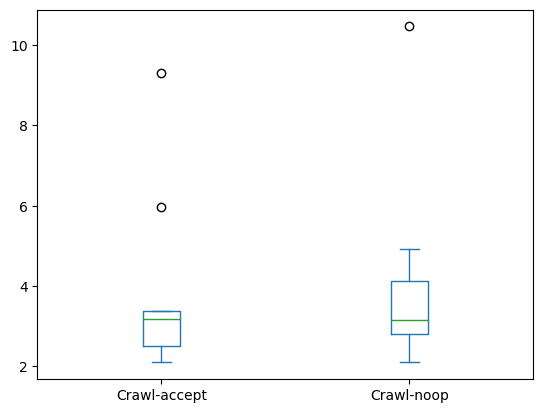

In [6]:
load_time_accept = []
load_time_noop = []

def page_load_time(data):
    difference = data['pageLoadEndTimestamp'] - data['pageLoadStartTimestamp']
    if difference <0:
        time = 0
    else:
        time = difference/1000
    return (time)

def fill_page_load_lists(accept_list,noop_list ):
    for crawl_accept in accept_list:
        load_time_accept.append(page_load_time(crawl_accept))
    for crawl_noop in noop_list:
        load_time_noop.append(page_load_time(crawl_noop))


fill_page_load_lists(accept_list,noop_list )
print (load_time_accept )
print (load_time_noop )
page_load_time_boxplot = { 'Crawl-accept': load_time_accept , 'Crawl-noop': load_time_noop}


df = pd.DataFrame(page_load_time_boxplot)
df.plot(kind='box')


##### b. Number of requests


[0, 6, 9, 0, 3, 0, 13, 0, 225]
[0, 6, 7, 0, 2, 0, 10, 0, 85]


<Axes: >

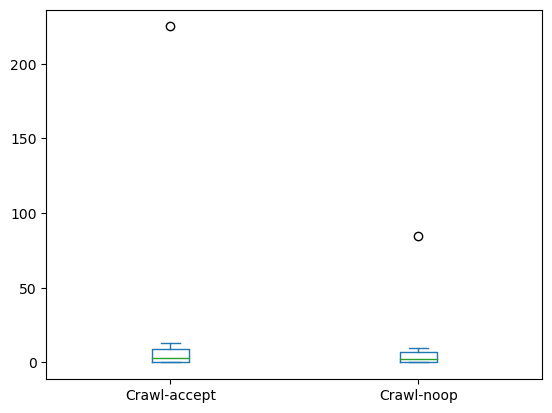

In [7]:
nr_request_data_noop = []
nr_request_data_accept = [] 

def num_requests(data):
    return len(data['httpRequests'])

def fill_request_lists(accept_list,noop_list):
    for crawl_accept in accept_list:
        nr_request_data_accept.append(num_requests(crawl_accept))
    for crawl_noop in noop_list:
        nr_request_data_noop.append(num_requests(crawl_noop))

fill_request_lists(accept_list,noop_list)
request_boxplot = { 'Crawl-accept': nr_request_data_accept, 'Crawl-noop': nr_request_data_noop}

print (nr_request_data_accept)
print (nr_request_data_noop)

df = pd.DataFrame(request_boxplot)
df.plot(kind='box')


    

##### c. Number of distinct third parties

[0, 0, 0, 0, 0, 0, 0, 0, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 6]


<Axes: >

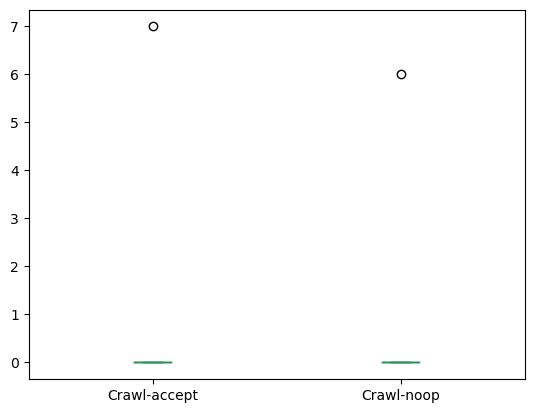

In [8]:
nr_distinct_third_party_accept = []
nr_distinct_third_party_noop = []


def distinct_third_parties(requests,main_domain):
    third_parties = set()
    for request in requests:
        url = request['requestURL']
        req_domain = get_fld(url)
        if req_domain not in main_domain:
            third_parties.add(req_domain)
    return len(third_parties)  
        

def fill_distinct_list(accept_list,noop_list):
    for crawl_accept in accept_list:
        website_domain = crawl_accept['domain'] 
        nr_distinct_third_party_accept.append(distinct_third_parties(crawl_accept['httpRequests'], website_domain)) 
    for crawl_noop in noop_list:
        website_domain = crawl_noop['domain'] 
        nr_distinct_third_party_noop.append(distinct_third_parties(crawl_noop['httpRequests'], website_domain))

fill_distinct_list(accept_list,noop_list)
third_party_boxplot = { 'Crawl-accept': nr_distinct_third_party_accept , 'Crawl-noop': nr_distinct_third_party_noop}

print(nr_distinct_third_party_accept)
print (nr_distinct_third_party_noop)

df = pd.DataFrame(third_party_boxplot)
df.plot(kind='box')

## er zijn alleen maar requests van hetzelfde domain in de huidige data

##### d. Number of distinct tracker domains


In [9]:
#per website
nr_tracker_domains_accept = []
nr_tracker_domains_noop = []

tracker_domains_accept = []
tracker_domains_noop =[]

## using Mozilla’s trackingprotection-tools library. to check wether the domain is a tracker
def blocklisted_tracker(domain):
    return trackingprotection_tools.DisconnectParser('services.json').should_block(domain)


def fill_tracker_domains_cookies(noop_list, accept_list):
    for crawl_accept in accept_list:
        distinct_cookies = []
        if crawl_accept['cookies']:
            for cookie in crawl_accept['cookies']:
                if blocklisted_tracker(cookie['domain']):
                    if cookie['domain'] not in distinct_cookies:
                        distinct_cookies.append(cookie['domain']) 
        tracker_domains_accept.append(distinct_cookies)
        nr_tracker_domains_accept.append(len(distinct_cookies))
    for crawl_noop in noop_list:
        distinct_cookies = []
        if crawl_noop['cookies']:
            for cookie in crawl_noop['cookies']:
                if blocklisted_tracker(cookie['domain']):
                    if cookie['domain'] not in distinct_cookies:
                        distinct_cookies.append(cookie['domain']) 
        tracker_domains_noop.append(distinct_cookies)
        nr_tracker_domains_noop.append(len(distinct_cookies))


#fill_tracker_domains(noop_list, accept_list)  
fill_tracker_domains_cookies(noop_list, accept_list)



distinct_tracker_domain_boxplot = { 'Crawl-accept': nr_tracker_domains_accept, 'Crawl-noop': nr_tracker_domains_noop}

print (nr_tracker_domains_accept)
print(nr_tracker_domains_noop)

df = pd.DataFrame(distinct_tracker_domain_boxplot)
df.plot(kind='box')

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 172: character maps to <undefined>

##### e. Number of distinct tracker entities/companies

[]
[]


<Axes: >

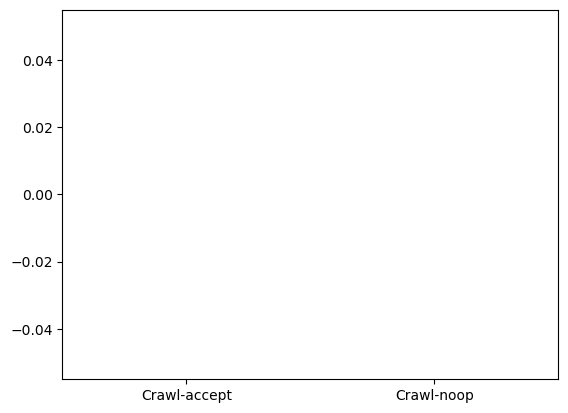

In [10]:
#per website
nr_distinct_tracker_entities_accept = []
nr_distinct_tracker_entities_noop = []


def fill_distinct_entities(domains_accept, domains_noop):
    for website in domains_accept:
        distinct_entities = []
        for cookie in website:
            if cookie in entity_list:
                if entity_list[cookie]['displayName'] not in distinct_entities:
                    distinct_entities.append(entity_list[cookie]['displayName'])
        nr_distinct_tracker_entities_accept.append(len(distinct_entities))
    for website in domains_noop:
        distinct_entities = []
        for cookie in website:
            if cookie in entity_list:
                if entity_list[cookie]['displayName'] not in distinct_entities:
                    distinct_entities.append(entity_list[cookie]['displayName'])
        nr_distinct_tracker_entities_noop.append(len(distinct_entities))
    

fill_distinct_entities(tracker_domains_accept,tracker_domains_noop)


distinct_entity_domain_boxplot = { 'Crawl-accept': nr_distinct_tracker_entities_accept, 'Crawl-noop': nr_distinct_tracker_entities_noop}


print (nr_distinct_tracker_entities_accept)
print (nr_distinct_tracker_entities_noop)

df = pd.DataFrame(distinct_entity_domain_boxplot)
df.plot(kind='box')

### 3: Comparison Crawl-accept vs Crawl-noop (table)

In [11]:
#data
nr_request_data_noop = []
nr_request_data_accept = [] 

def calc_median(data):
    if data == []:
        return 0
    else:
        return statistics.median(data)
    

page_load_time = [min(load_time_accept, default=0),calc_median(load_time_accept),max(load_time_accept,default=0),min(load_time_noop, default=0)
                  ,calc_median(load_time_noop),max(load_time_noop, default=0)]
                  

number_of_requests= [min(nr_request_data_accept,default=0), calc_median(nr_request_data_accept),max(nr_request_data_accept,default=0)
                     ,min(nr_request_data_noop,default=0),calc_median(nr_request_data_noop),max(nr_request_data_noop, default=0)]
                     

number_of_distinct_third_parties= [min(nr_distinct_third_party_accept,default=0),calc_median(nr_distinct_third_party_accept)
                                   ,max(nr_distinct_third_party_accept, default=0),min(nr_distinct_third_party_noop,default=0),
                                   calc_median(nr_distinct_third_party_noop),max(nr_distinct_third_party_noop, default=0)]
                                  

number_of_distinct_tracker_domains = [min(nr_tracker_domains_accept,default=0),calc_median(nr_tracker_domains_accept),
                                      max(nr_tracker_domains_accept, default=0),min(nr_tracker_domains_noop, default=0),
                                      calc_median(nr_tracker_domains_noop),max(nr_tracker_domains_noop, default=0)]
                                      

number_ofdistinct_tracker_companies = [min(nr_distinct_tracker_entities_accept,default=0),calc_median(nr_distinct_tracker_entities_accept)
                                       ,max(nr_distinct_tracker_entities_accept, default=0), min(nr_distinct_tracker_entities_noop, default=0)
                                       ,calc_median(nr_distinct_tracker_entities_noop),max(nr_distinct_tracker_entities_noop, default=0)]


comparison_data = [page_load_time,number_of_requests,number_of_distinct_third_parties,number_of_distinct_tracker_domains,number_ofdistinct_tracker_companies]
df = pd.DataFrame(comparison_data,
                  index=pd.Index(['Page load time', 'Number of requests', 'Number of distinct third parties', 'Number of distinct tracker domains'
                                  , 'Number of distinct tracker entities/companies' ], name=''),
                  columns=pd.MultiIndex.from_product([['Crawl-accept', 'Crawl-noop'],['Min', 'Median', 'Max']], names=['', 'Metric']))

df

Crawl-accept                \
Metric                                                 Min Median    Max   
                                                                           
Page load time                                       2.107  3.182  9.312   
Number of requests                                   0.000  0.000  0.000   
Number of distinct third parties                     0.000  0.000  7.000   
Number of distinct tracker domains                   0.000  0.000  0.000   
Number of distinct tracker entities/companies        0.000  0.000  0.000   

                                              Crawl-noop                 
Metric                                               Min Median     Max  
                                                                         
Page load time                                     2.098  3.163  10.465  
Number of requests                                 0.000  0.000   0.000  
Number of distinct third parties                   0.000  0.000   6.000  
Number of distinct tracker domains                 0.000  0.000   0.000  
Number of distinct tracker entities/companies      0.000  0.000   0.000

### 4: Table of the Ten most prevalent third-party domains 
##### (based on the number of distinct websites where the third party is present)

In [12]:
cookies = {}
# domain : (nr. of occurrences in accept, nr. of occurrences in noop)

is_tracker = {}
# domain : "Yes"/"No"

def increment_accept(tuple):
    return ((tuple[0]+1, tuple[1]))

def increment_noop(tuple):
    return ((tuple[0], tuple[1]+1))

def add_distinct_cookies(list, mode):
    for entry in list:
        if entry['cookies']:
            entry_cookies = []
            for cookie in entry['cookies']:
                if cookie['domain'] not in entry_cookies:
                    if mode == 'accept':
                        cookies[cookie['domain']] = increment_accept(cookies.get(cookie['domain'], (0,0)))
                    elif mode == 'noop':
                        cookies[cookie['domain']] = increment_noop(cookies.get(cookie['domain'], (0,0)))
                    entry_cookies.append(cookie['domain'])

add_distinct_cookies(accept_list, 'accept')
add_distinct_cookies(noop_list, 'noop')

top10 = sorted(cookies.items(), key=lambda x:-x[1][0])[:10]

with open("entities.json", "r", encoding="utf8") as tracker_file:
    file_contents = tracker_file.read()
trackers = json.loads(file_contents)['entities']
for tracker in trackers:
    if trackers[tracker]['properties']:
        for domain in trackers[tracker]['properties']:
            for item in top10:
                if domain == item[0]:
                    is_tracker[domain] = "Yes"

empty_third_party_table = {'Third-party domain' : [x[0] for x in top10], 
                           'Crawl-accept':[0]*len(top10),
                           'Crawl-noop': [0]*len(top10),
                           'isTracker?': ["No"]*len(top10)}

# Disable chained assignment warnings
pd.options.mode.chained_assignment = None

third_party_table = pd.DataFrame(empty_third_party_table).set_index('Third-party domain')
for entry in top10:
    third_party_table['Crawl-accept'][entry[0]] = entry[1][0]
    third_party_table['Crawl-noop'][entry[0]] = entry[1][1]
    third_party_table['isTracker?'][entry[0]] = is_tracker.get(entry[0], "No")

print(third_party_table)
    

                    Crawl-accept  Crawl-noop isTracker?
Third-party domain                                     
.facebook.com                  1           0         No
.google.com                    1           1         No
.instagram.com                 1           0         No
.linkedin.com                  1           1         No
.www.linkedin.com              1           1         No
.microsoft.com                 1           1         No
www.microsoft.com              1           1         No
.netflix.com                   1           1         No
.twitter.com                   1           1         No
.wikipedia.org                 1           1         No


### 5: Scatter plot of:
##### Y: Number of distinct tracker domains
##### VS
##### X: Website’s Tranco rank
###### (for each crawl)

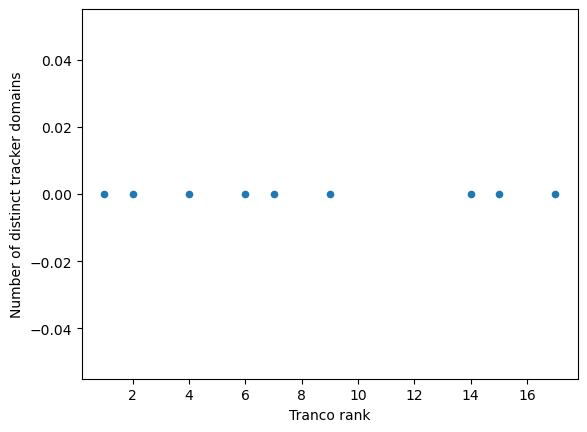

In [13]:
tranco = {}
distinct_trackers = {}

def check_if_tracker(cookie_domain):
    for tracker in trackers:
        if trackers[tracker]['properties']:
            for domain in trackers[tracker]['properties']:
                if domain == cookie_domain:
                    return True
    return False    

for entry in accept_list:
    distinct_trackers[entry['domain']] = 0
    if entry['cookies']:
        entry_cookies = []
        for cookie in entry['cookies']:
            if cookie['domain'] not in entry_cookies:
                entry_cookies.append(cookie['domain'])
                if check_if_tracker(cookie['domain']):
                    distinct_trackers[entry['domain']] += 1
    
import csv   
with open('top-1m.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        for entry in accept_list:
            if row[1] == entry['domain']:
                tranco[entry['domain']] = row[0]
    
tranco_tracker = []
for entry in tranco:
    tranco_tracker.append([int(tranco[entry]), int(distinct_trackers[entry])])
    
df = pd.DataFrame(tranco_tracker, columns=['Tranco rank', 'Number of distinct tracker domains'])
ax1 = df.plot.scatter(x='Tranco rank', y='Number of distinct tracker domains')

### 6: Table of the Top ten tracker entities (companies) and their prevalence
##### (based on the number of distinct websites where the entity is present). Similar to the table in 4, but should only contain tracker entities).

In [14]:
tracker_entities = {}

with open("domain_map.json", "r", encoding="utf8") as domain_map_file:
    domain_map = json.loads(domain_map_file.read())
    for cookie in cookies:
        if cookie in domain_map:
            tracker_entities[domain_map[cookie]['displayName']] = tracker_entities.get(domain_map[cookie]['displayName'], 0) + 1

top10_trackers = sorted(tracker_entities.items(), key=lambda x:-x[1])[:10]
    
empty_tracker_table = {'Entity name' : [x[0] for x in top10_trackers],
                       'Number of distinct websites': [0]*len(top10_trackers)}
tracker_table = pd.DataFrame(empty_tracker_table).set_index('Entity name')
for entry in top10_trackers:
    tracker_table['Number of distinct websites'][entry[0]] = entry[1]
    
print(tracker_table)

Empty DataFrame
Columns: [Number of distinct websites]
Index: []


### 7: Find the three cookies with the longest lifespans **for each crawl**
##### Add a separate table for each crawl having the following columns (see assignment). Only include the first 5 characters of the Value attribute.

In [15]:
import datetime

def print_tables(entry_list):
    empty_top3_cookie_data_table = {'Name' : [""],
                                    'Value' : [""],
                                    'Domain' : [""],
                                    'Path' : [""],
                                    'Expires' : [""],
                                    'Size' : [0],
                                    'HttpOnly' : [""],
                                    'Secure' : [""],
                                    'SameSite' : [""],
                                    }
    top3_cookie_data_table = pd.DataFrame(empty_top3_cookie_data_table).set_index('Name')
    for entry in entry_list:
        top3_cookie_data_table.sort_values(by=['Expires'], ascending=False, inplace=True)
        if entry['cookies']:
            empty_cookie_data_table = {'Name' : [cookie['name'] for cookie in entry['cookies']],
                                    'Value' : [""]*len(entry['cookies']),
                                    'Domain' : [""]*len(entry['cookies']),
                                    'Path' : [""]*len(entry['cookies']),
                                    'Expires' : [""]*len(entry['cookies']),
                                    'Size' : [0]*len(entry['cookies']),
                                    'HttpOnly' : [""]*len(entry['cookies']),
                                    'Secure' : [""]*len(entry['cookies']),
                                    'SameSite' : [""]*len(entry['cookies']),
                                    }
            cookie_data_table = pd.DataFrame(empty_cookie_data_table).set_index('Name')
            for cookie in entry['cookies']:
                cookie_data_table['Value'][cookie['name']]      = cookie['value'][:5]
                cookie_data_table['Domain'][cookie['name']]     = cookie['domain']
                cookie_data_table['Path'][cookie['name']]       = cookie['path']
                if isinstance(cookie['expiry'], int):
                    secs = int(cookie['expiry']) / 100
                    cookie_data_table['Expires'][cookie['name']]    = datetime.datetime.fromtimestamp(secs).strftime('%Y-%m-%d %H:%M:%S')
                cookie_data_table['Size'][cookie['name']]       = len(cookie['value'])
                cookie_data_table['HttpOnly'][cookie['name']]   = cookie['httpOnly']
                cookie_data_table['Secure'][cookie['name']]     = cookie['secure']
                cookie_data_table['SameSite'][cookie['name']]   = cookie['sameSite']
            cookie_data_table.sort_values(by=['Expires'], ascending=False, inplace=True)
            top3_cookie_data_table = pd.concat([top3_cookie_data_table.head(3), cookie_data_table.head(3)])
    print(top3_cookie_data_table.head(3))

print_tables(accept_list)
print_tables(noop_list)


        Value          Domain Path              Expires  Size HttpOnly Secure  \
Name                                                                            
mid     ZH35q  .instagram.com    /  2515-03-21 07:52:20    28    False   True   
ig_did  22D84  .instagram.com    /  2515-03-21 07:52:20    36     True   True   
dsca    anony    .netflix.com    /  2515-03-21 07:45:40     9    False  False   

       SameSite  
Name             
mid         Lax  
ig_did      Lax  
dsca        Lax  
                Value             Domain Path              Expires  Size  \
Name                                                                       
G_ENABLED_IDPS  googl  .www.linkedin.com    /  2515-03-21 08:14:50     6   
CONSENT         PENDI        .google.com    /  2515-03-21 07:31:50    11   
guest_id        v1%3A       .twitter.com    /  2515-02-09 07:57:10    23   

               HttpOnly Secure SameSite  
Name                                     
G_ENABLED_IDPS    False  False      Lax

### 8: Find the three requests with the most cookies **for each crawl**

In [16]:
#creates a sorted list (descending, nr of cookies) of tuples with the domain and number of cookies
def find_most_cookies(websites):
    result = []
    for site in websites:
        result.append( (f"www.{site['domain']}", site['domain'], len(site['cookies']), 'Yes') )
    sorted_list = sorted(result, key=lambda x:x[2], reverse=True)
    return sorted_list[:3]
        
cookies_accept = find_most_cookies(accept_list)
df_accept = pd.DataFrame(cookies_accept, columns=["Request hostname", "Website", "Number of cookies", "First-party requests"])
print(df_accept)
cookies_noop = find_most_cookies(noop_list)
df_noop = pd.DataFrame(cookies_noop, columns=["Request hostname", "Website", "Number of cookies", "First-party requests"])
print(df_noop)


    Request hostname        Website  Number of cookies First-party requests
0  www.microsoft.com  microsoft.com                 23                  Yes
1    www.netflix.com    netflix.com                 10                  Yes
2    www.youtube.com    youtube.com                  7                  Yes
[('www.microsoft.com', 'microsoft.com', 12, 'Yes'), ('www.linkedin.com', 'linkedin.com', 9, 'Yes'), ('www.netflix.com', 'netflix.com', 6, 'Yes')]


### 9: Identify ten most common cross-domain HTTP redirection pairs 
#### that involve a tracker domain either in the source or the target(or both)

In [ ]:
# the current version of our crawler does not support this operation

### 10: Capture the Images drawn by the canvas fingerprinting scripts
#### Create a table (see assignment)

In [33]:
#saves a data url as image to the specified path
def save_image(data_url, path, name):
    output_file = f'{path}{name}.png'
    data = data_url.split(',')[1]
    image_data = base64.b64decode(data)
    image = Image.open(BytesIO(image_data))
    if image.mode != "RGBA":
        image = image.convert("RGBA")
    image.save(output_file, "PNG")


#check if a website is using fingerprinting, if yes, return the fingerprint, else None
def check_fingerprint (accept, noop):
    fingerprint = None
    if accept['isCanvasFingerprinting']:
        fingerprint = accept['toDataUrl']
    elif noop['isCanvasFingerprinting']:
        fingerprint = noop['toDataUrl']
    return fingerprint


#fill in the  crawl failure table
def save_fingerprint_images(website_pairs, path):
    for accept, noop in website_pairs:
        #if website uses finger printing, add it to the table
        fingerprint = check_fingerprint(accept, noop)
        if fingerprint:
            save_image(fingerprint, path, accept['domain'])

            

            
##create a folder fingerprints in working directory and store all fingerprints there
folder_name = 'fingerprints'
os.makedirs(folder_name, exist_ok=True)
fp_path = f'./{folder_name}/'
website_pairs = zip(accept_list,noop_list)
save_fingerprint_images(website_pairs, fp_path)

